In [38]:
import numpy as np
import matplotlib.pyplot as plt
import glob
%matplotlib notebook

In [31]:
data = np.load("train_data/renders/3_teleport_obj_points.npz")
data.files

['clouds', 'colors', 'classes', 'shapenet_id']

In [32]:
data['clouds']

array([[0.4445899 , 0.18728607, 1.28949582],
       [0.4473974 , 0.1865119 , 1.28981455],
       [0.44999298, 0.18632698, 1.29001502],
       ...,
       [0.48908245, 0.00768642, 1.36355277],
       [0.49119046, 0.0075646 , 1.36341715],
       [0.49330337, 0.00744252, 1.3632812 ]])

In [33]:
data['colors']

array([[223, 223, 223],
       [206, 206, 206],
       [192, 192, 192],
       ...,
       [154, 154, 154],
       [154, 154, 154],
       [154, 154, 154]], dtype=uint8)

In [34]:
data['classes']

array([0., 0., 0., ..., 2., 2., 2.])

In [35]:
data['shapenet_id']

array('5c48d471200d2bf16e8a121e6886e18d', dtype='<U32')

In [41]:
glob.glob("train_data/renders/*.npz")

['train_data/renders/3_teleport_obj_points.npz',
 'train_data/renders/4_teleport_obj_points.npz',
 'train_data/renders/0_teleport_obj_points.npz',
 'train_data/renders/14_teleport_obj_points.npz',
 'train_data/renders/22_teleport_obj_points.npz',
 'train_data/renders/2_teleport_obj_points.npz',
 'train_data/renders/1_teleport_obj_points.npz',
 'train_data/renders/11_teleport_obj_points.npz',
 'train_data/renders/10_teleport_obj_points.npz',
 'train_data/renders/28_teleport_obj_points.npz',
 'train_data/renders/8_teleport_obj_points.npz',
 'train_data/renders/6_teleport_obj_points.npz']

<IPython.core.display.Javascript object>


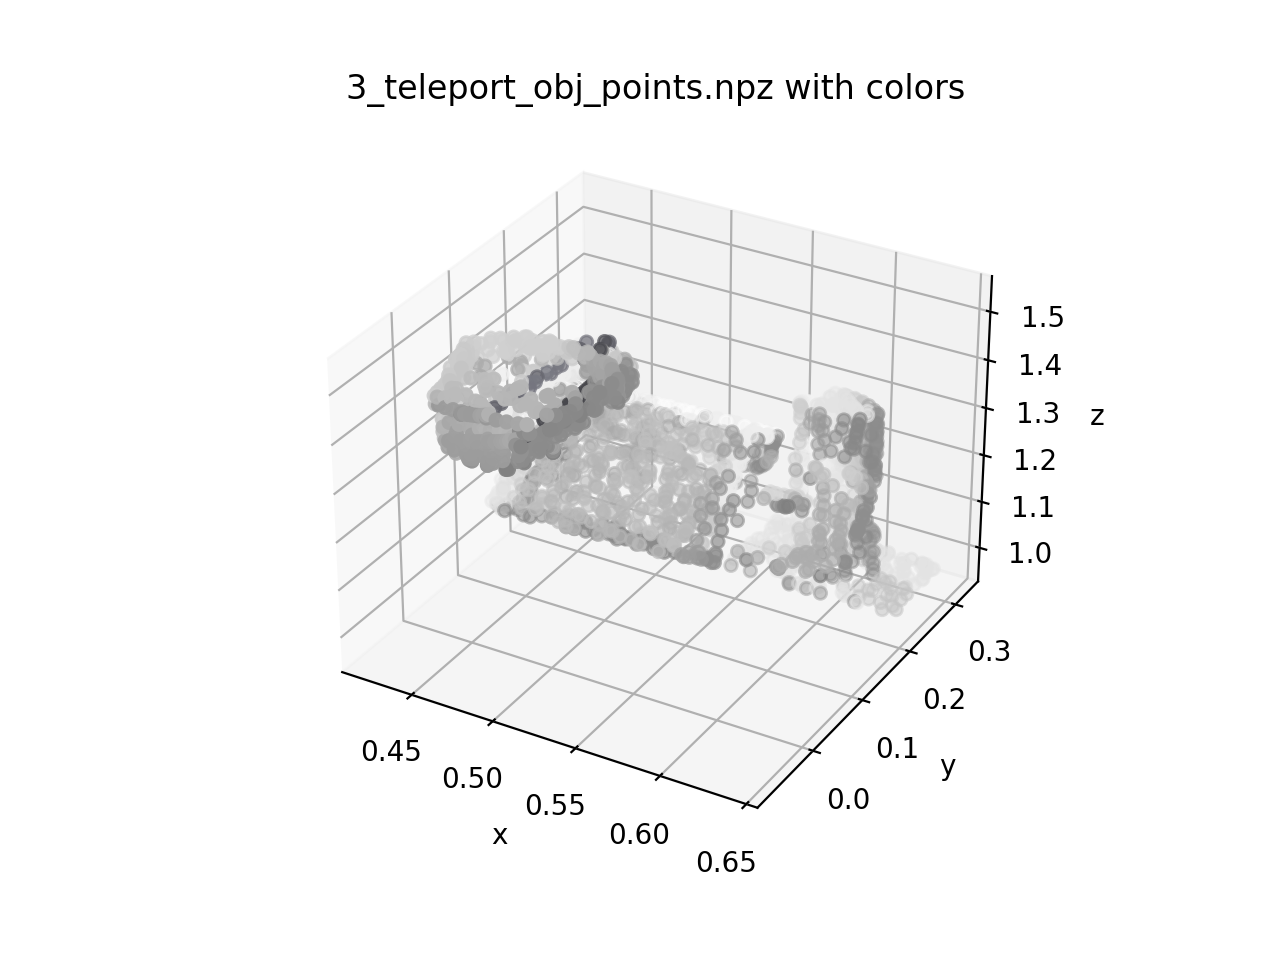

<IPython.core.display.Javascript object>


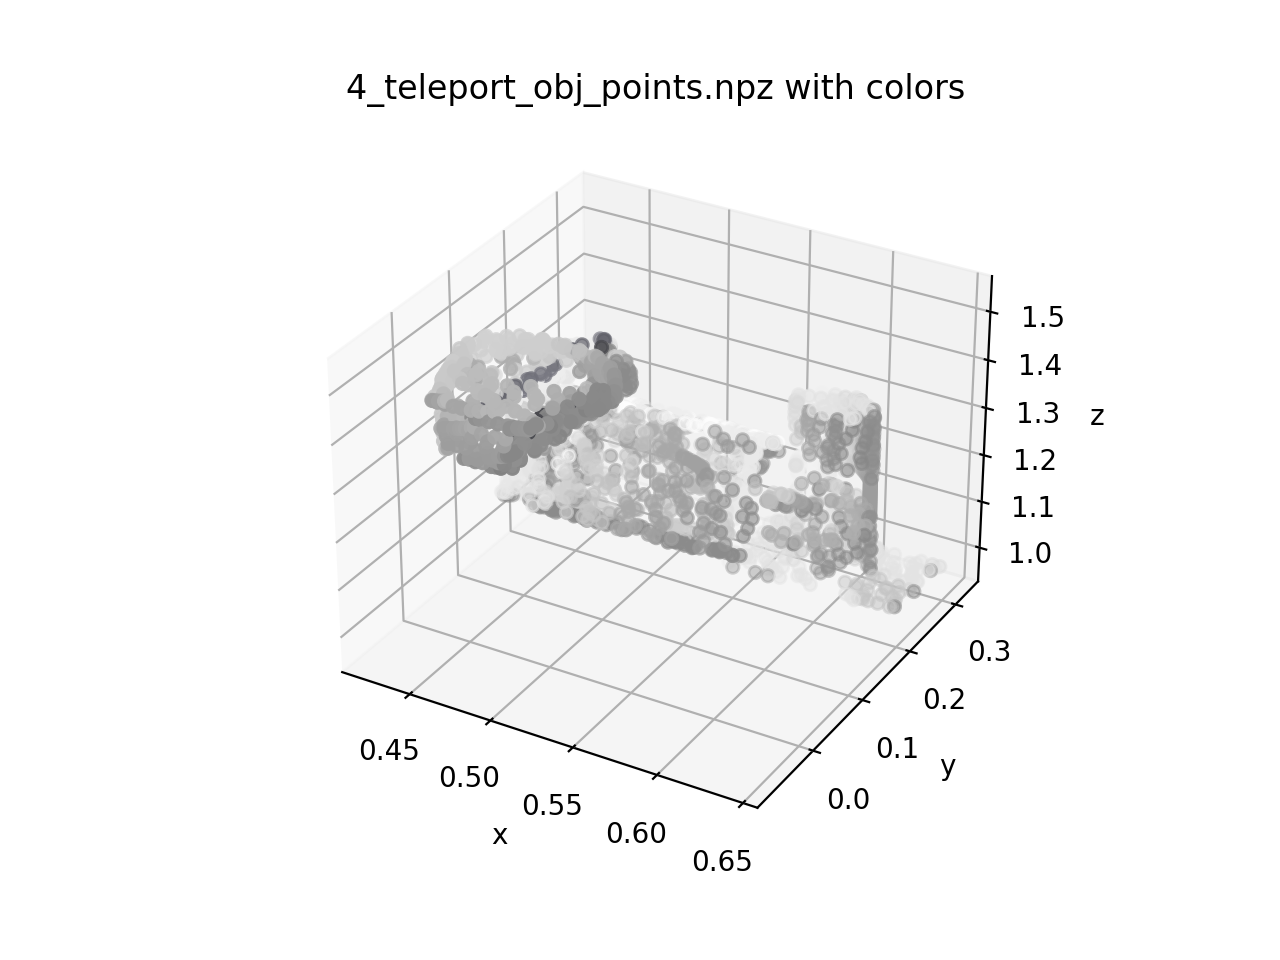

<IPython.core.display.Javascript object>


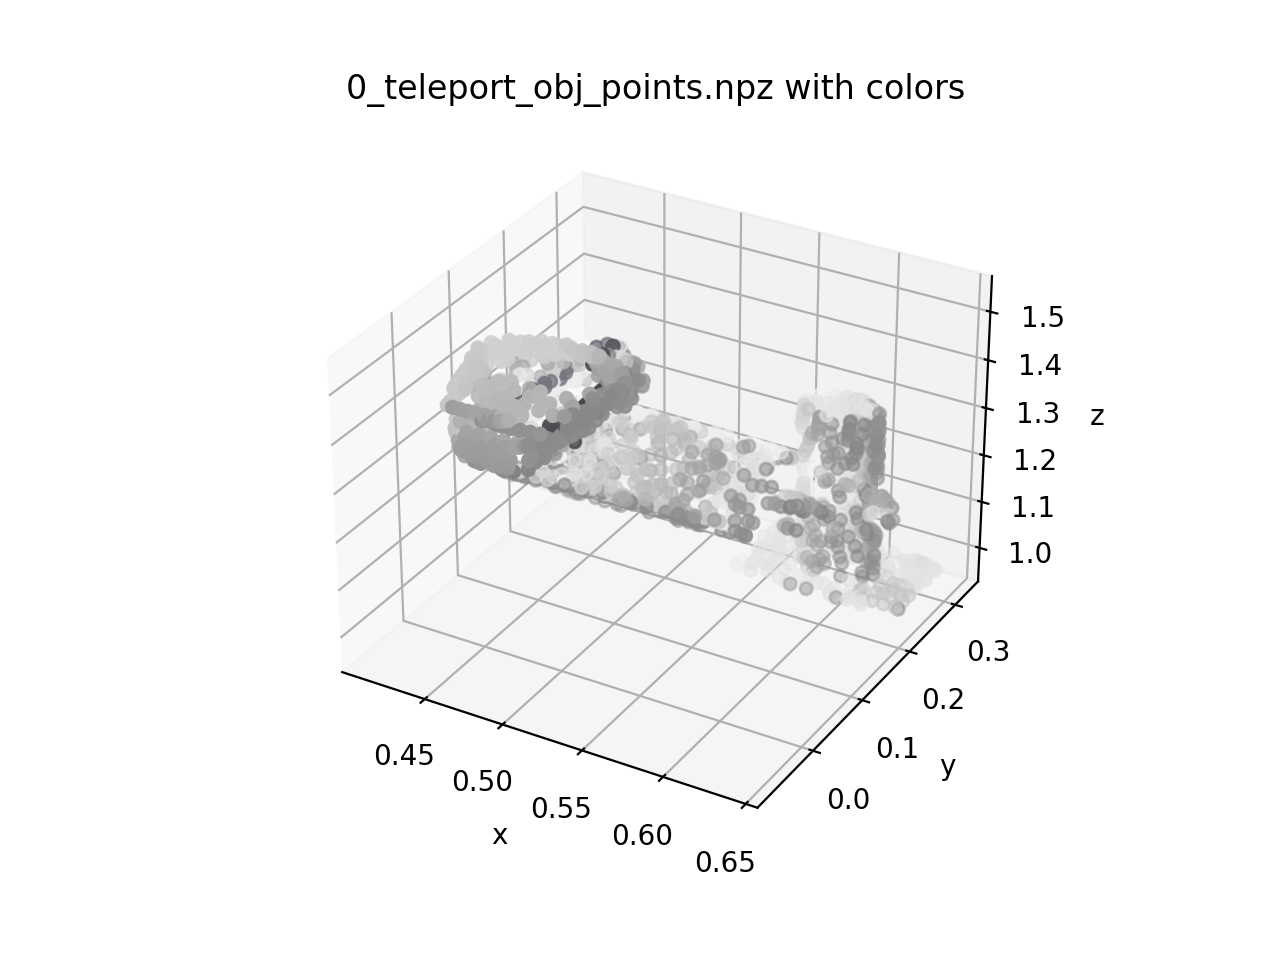

<IPython.core.display.Javascript object>


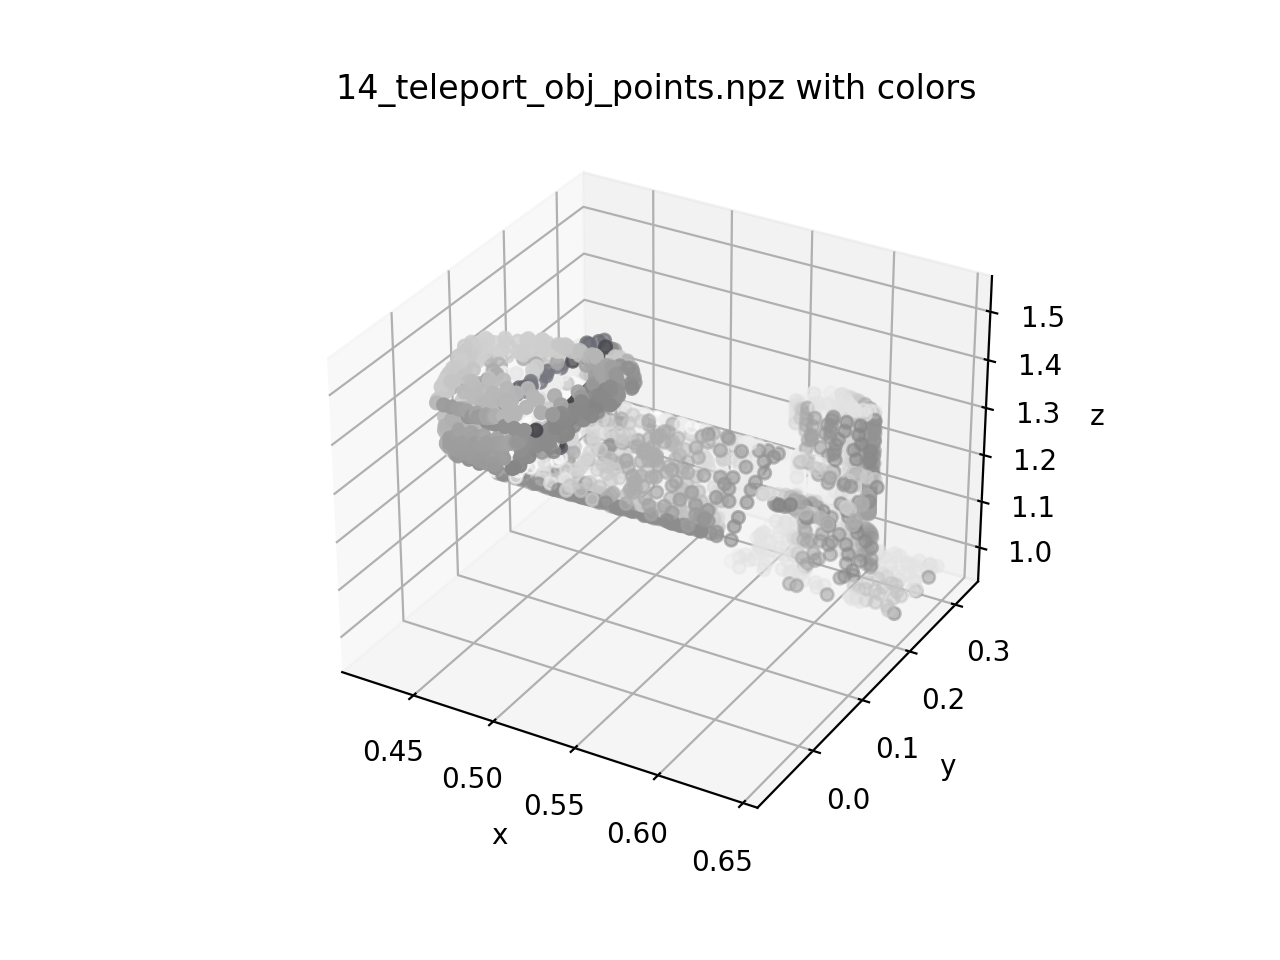

<IPython.core.display.Javascript object>


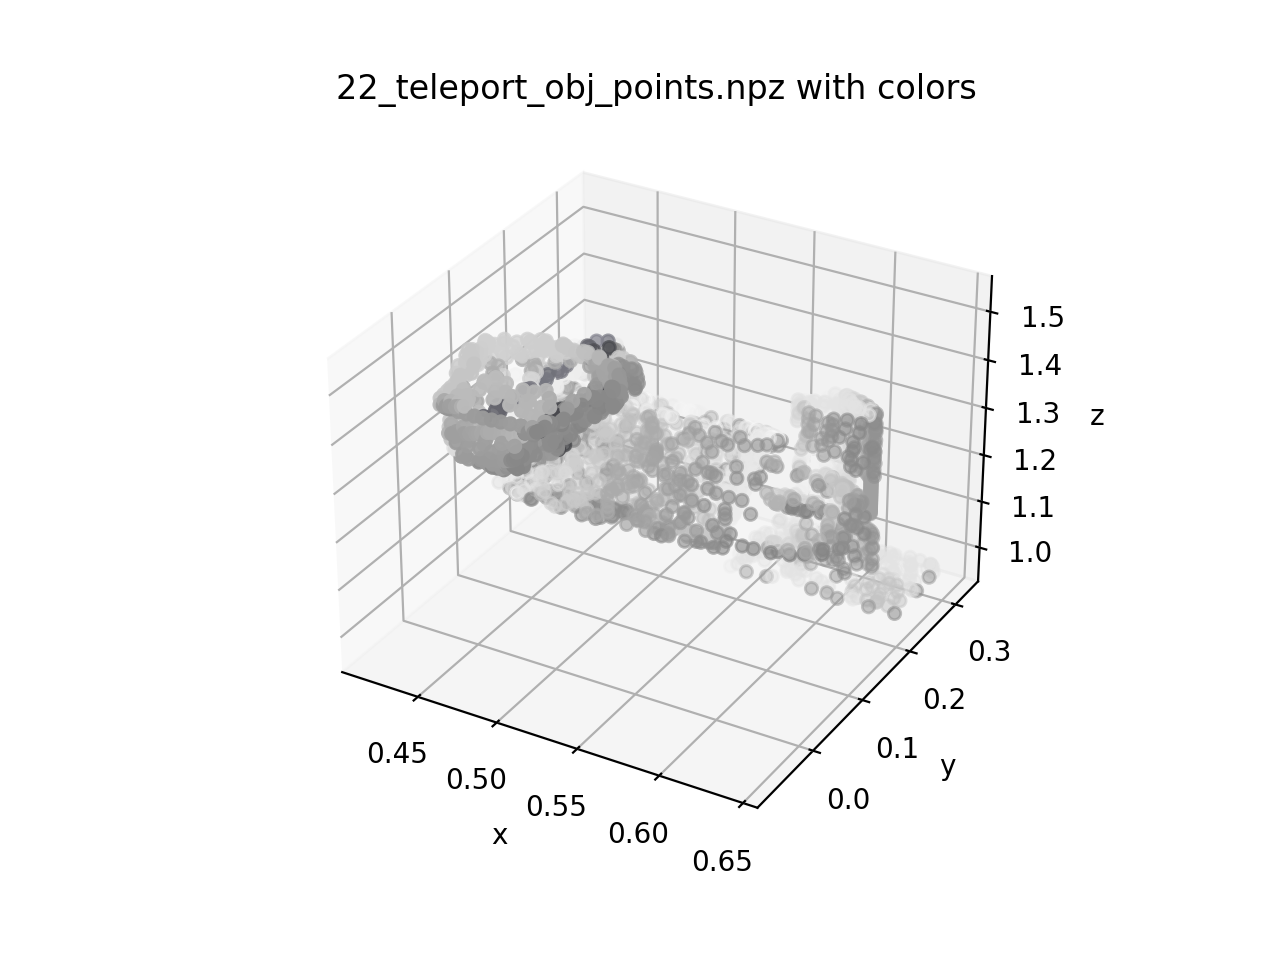

<IPython.core.display.Javascript object>


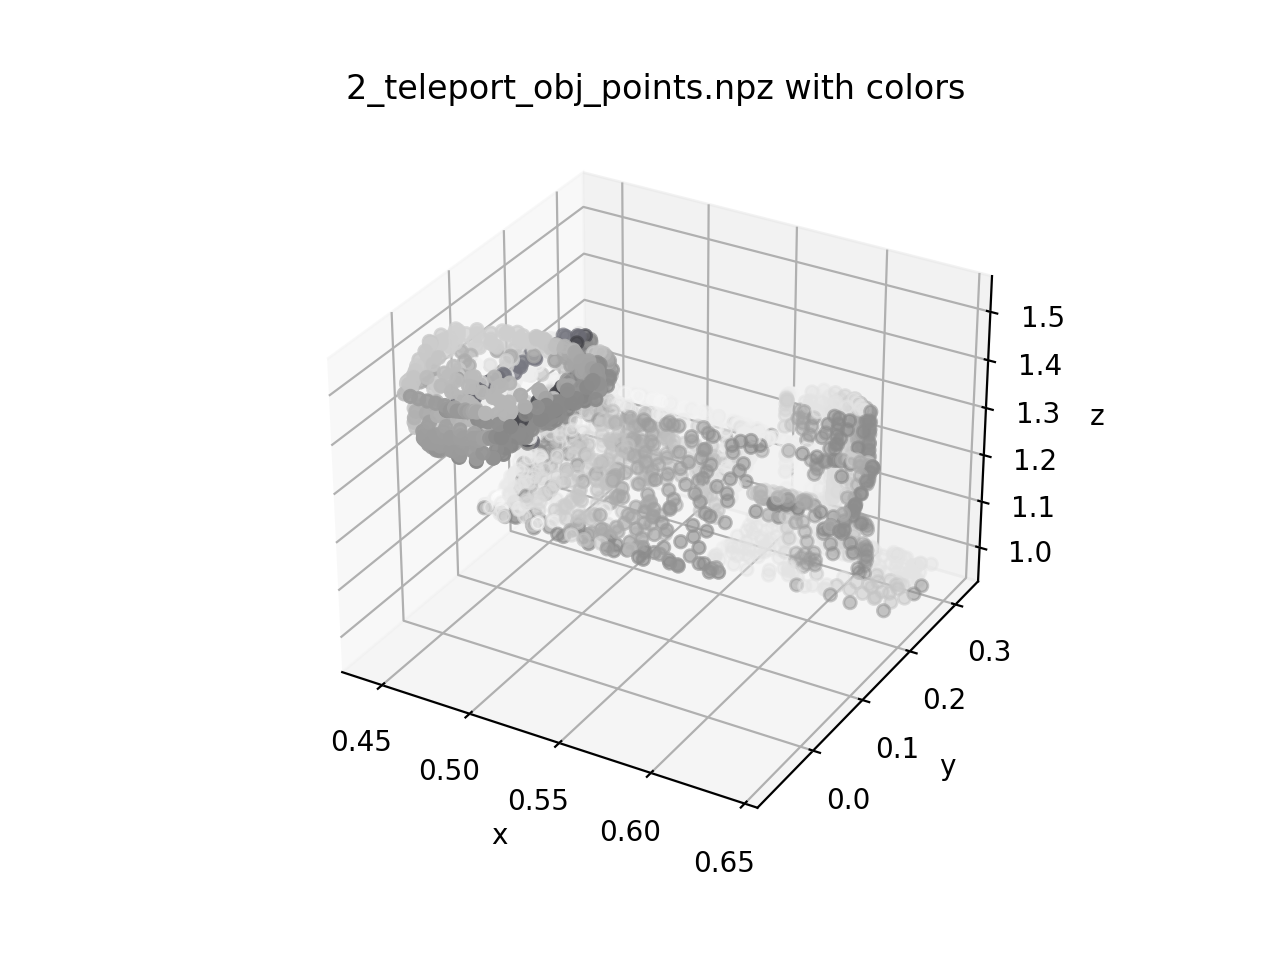

<IPython.core.display.Javascript object>


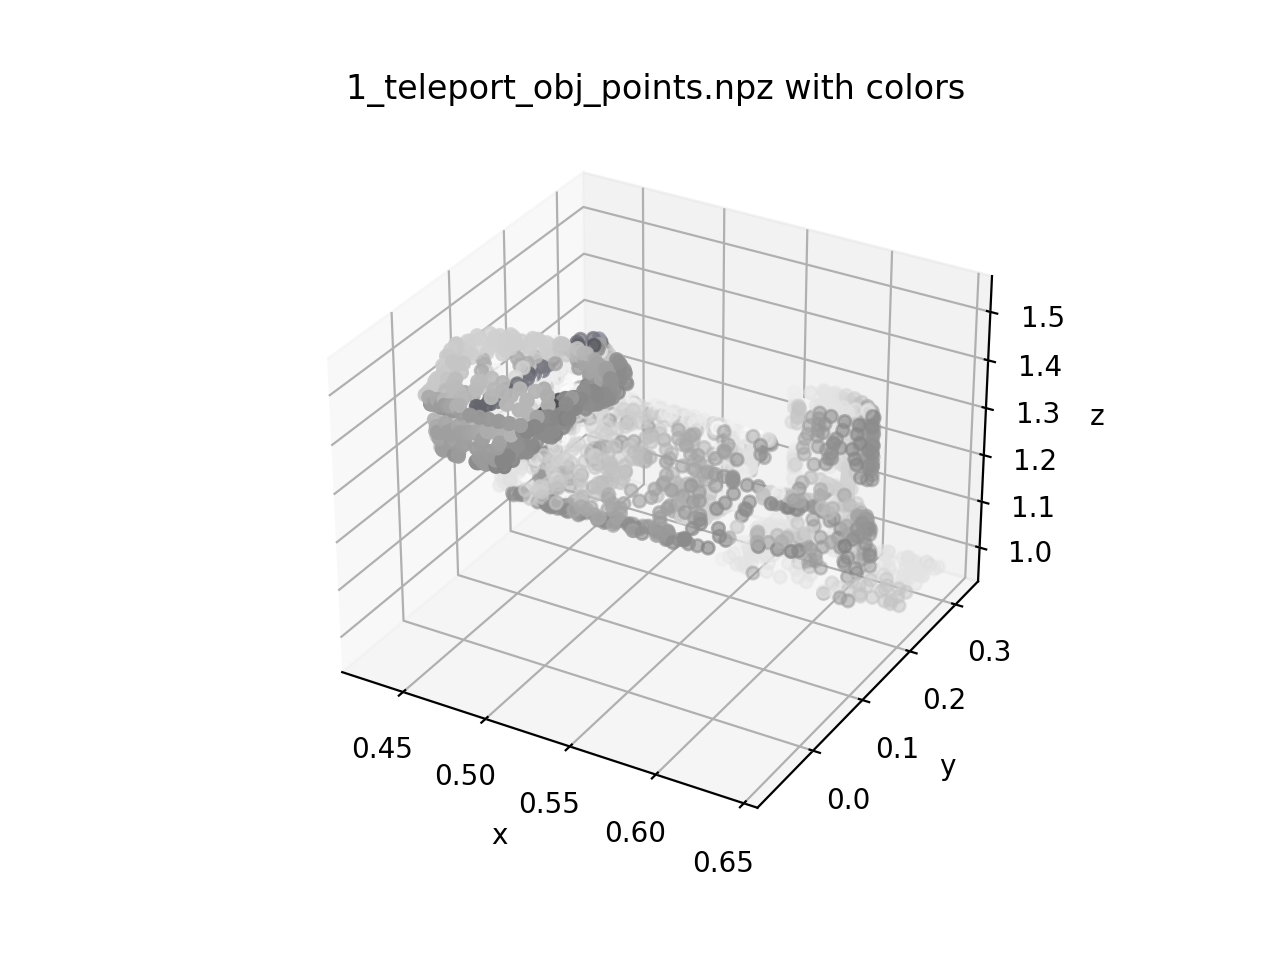

<IPython.core.display.Javascript object>


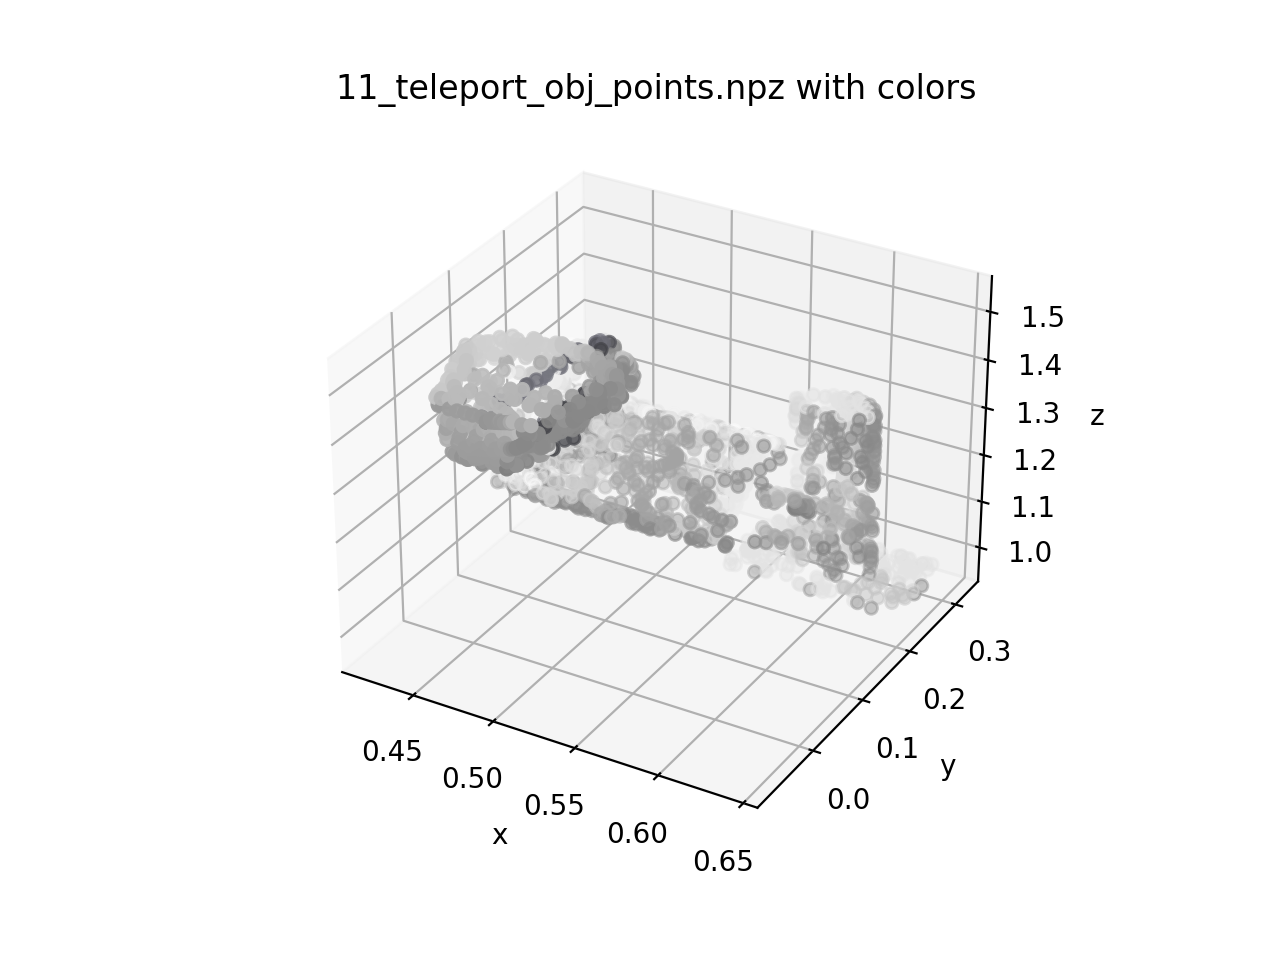

<IPython.core.display.Javascript object>


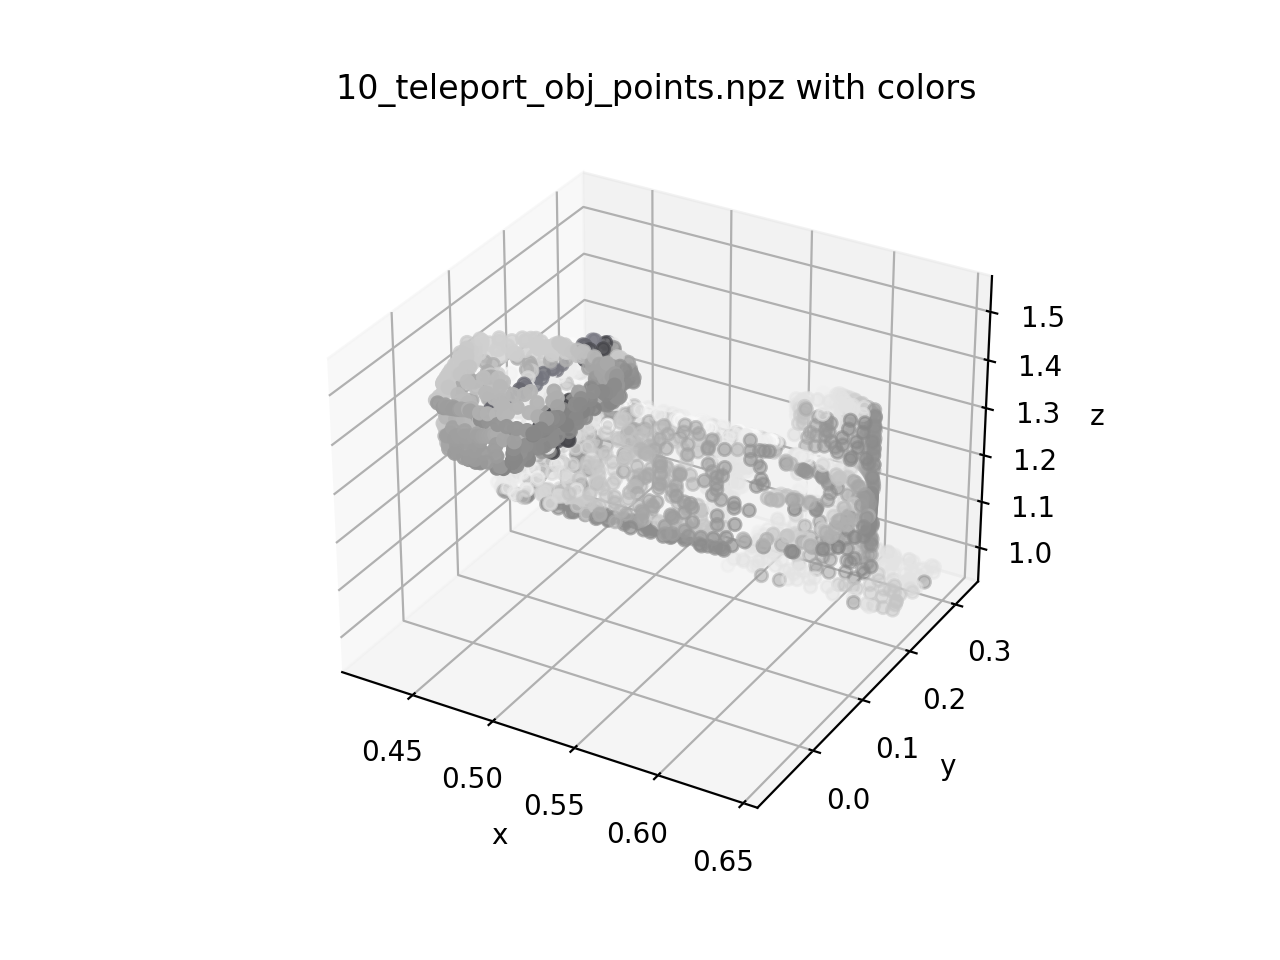

<IPython.core.display.Javascript object>


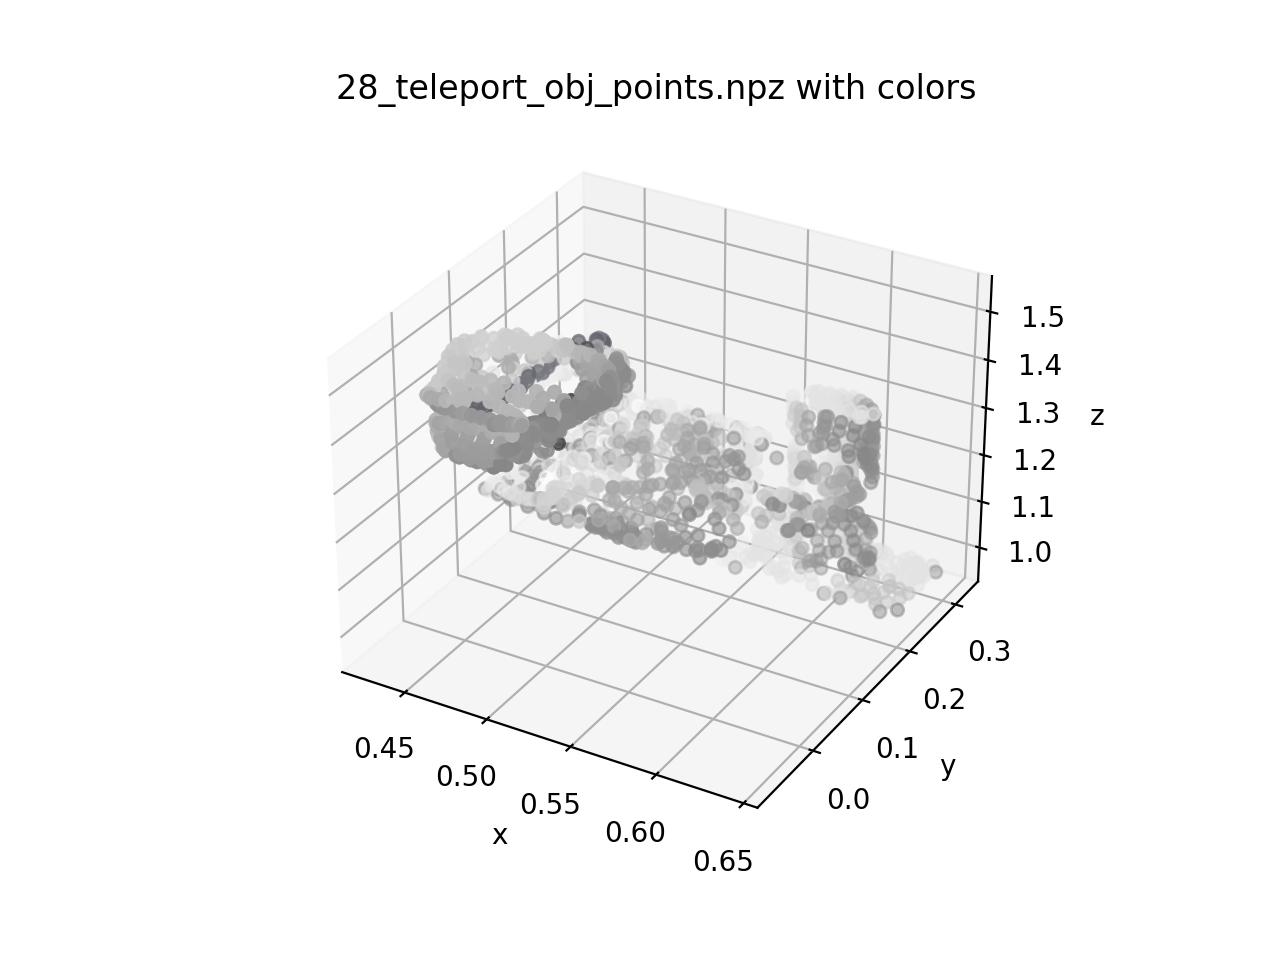

<IPython.core.display.Javascript object>


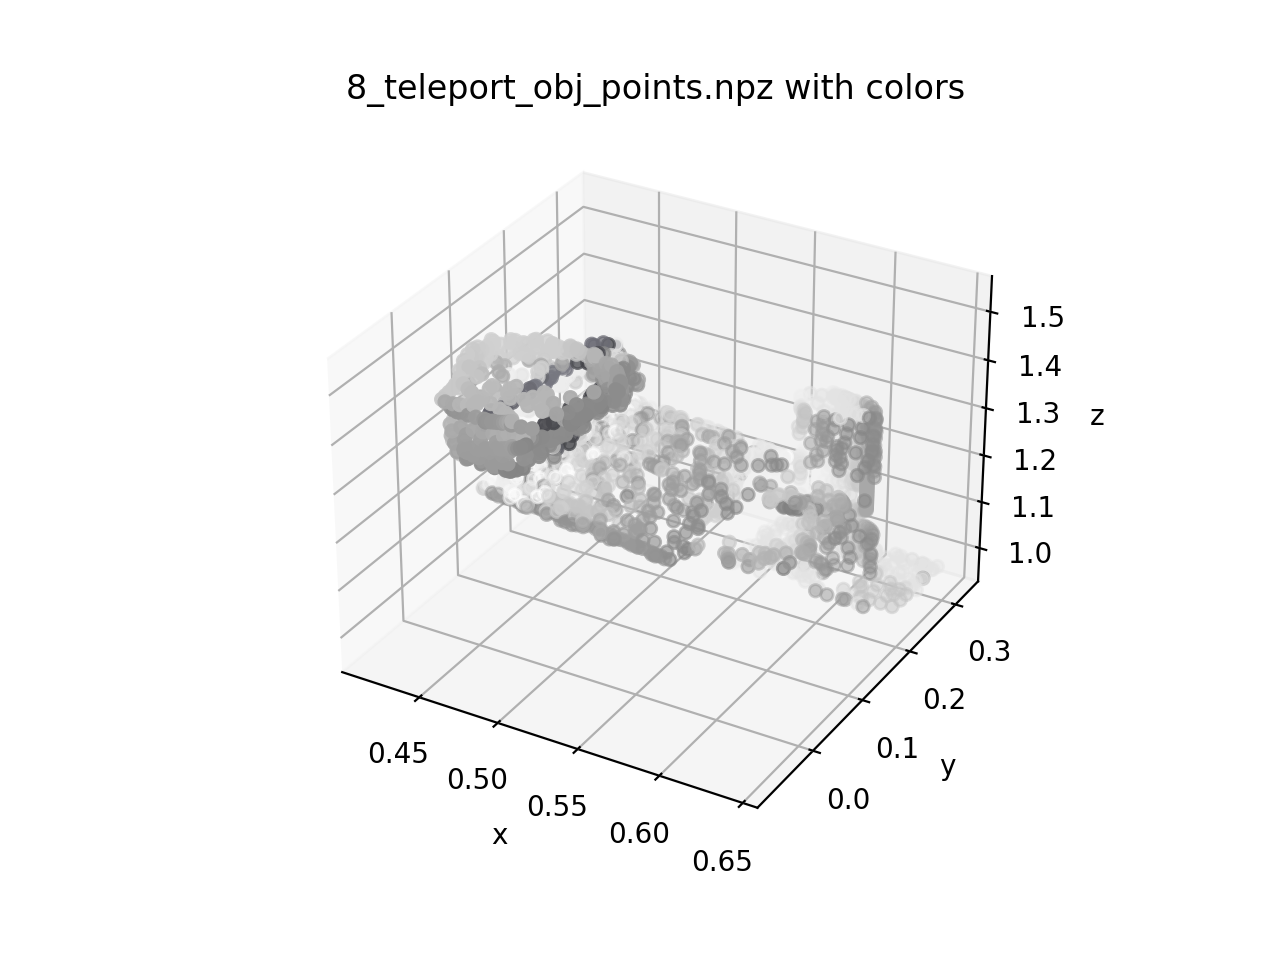

<IPython.core.display.Javascript object>


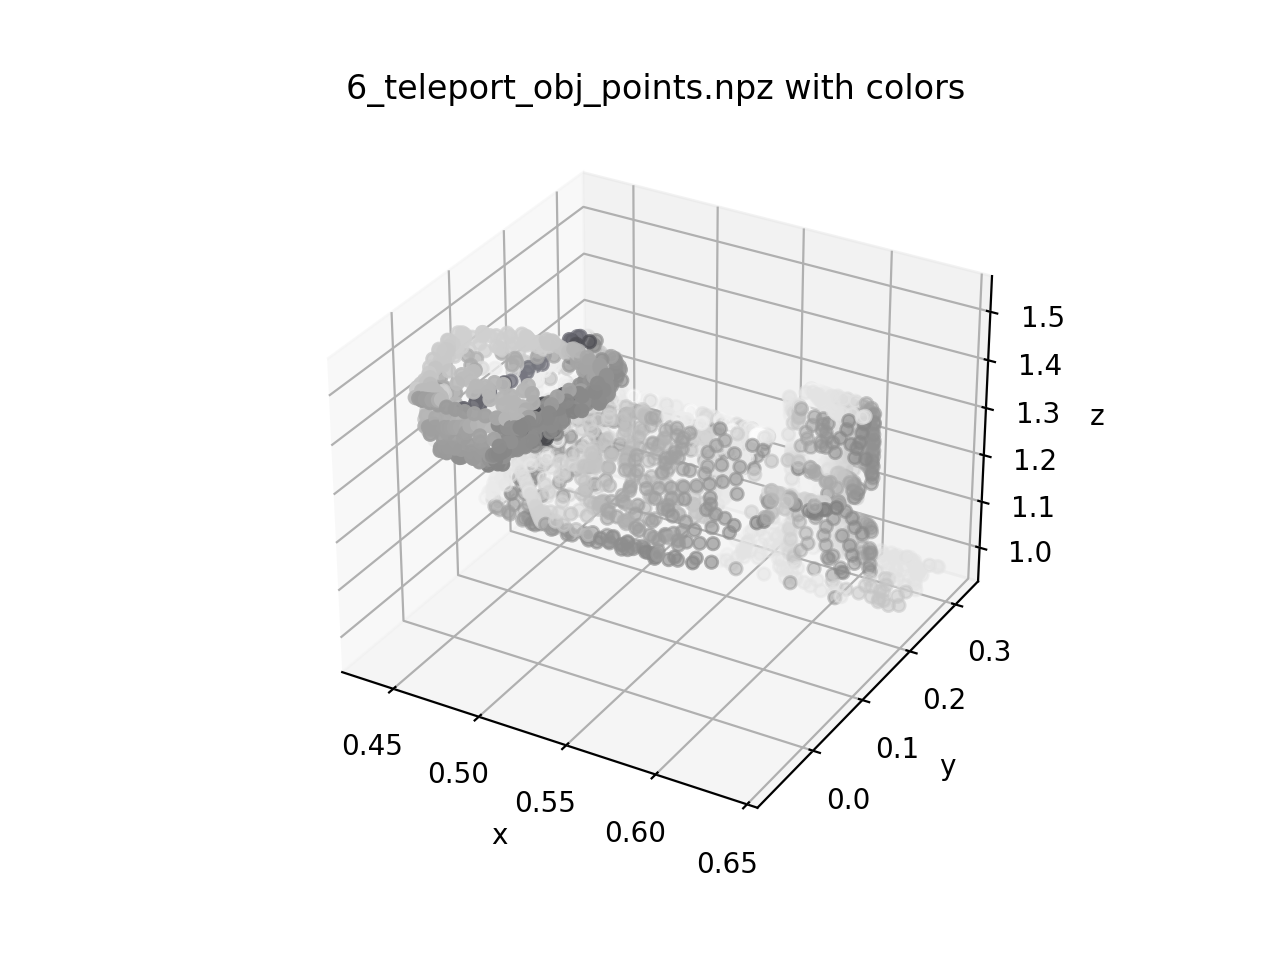

In [44]:
for filename in glob.glob("train_data/renders/*.npz"):
    data = np.load(filename)

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    ax.scatter(data['clouds'][::30,0], data['clouds'][::30,1], data['clouds'][::30,2], c=data['colors'][::30]/255)

    ax.set_title(filename.split("/")[-1] + " with colors")
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

<IPython.core.display.Javascript object>


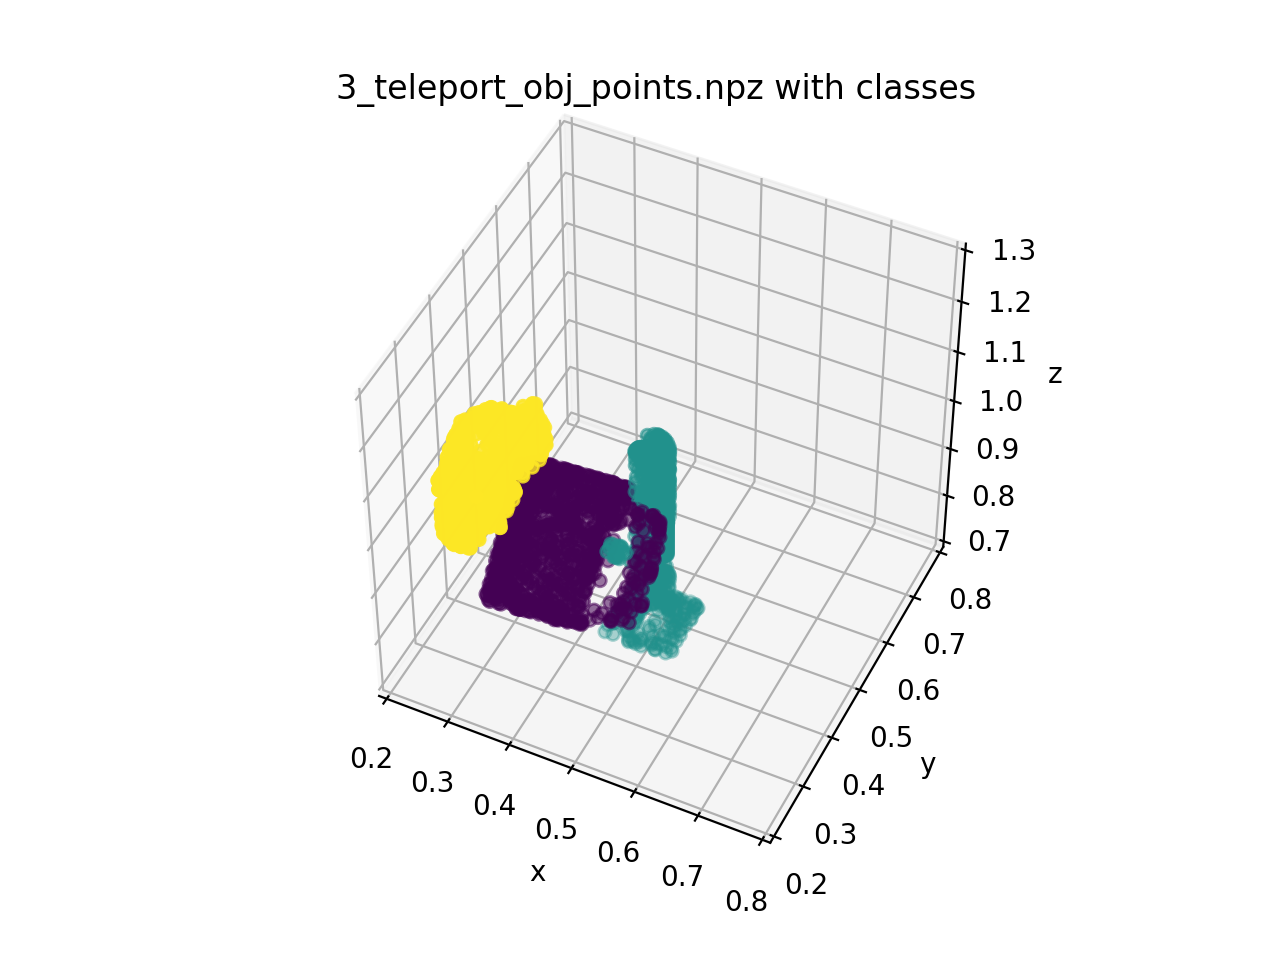

In [92]:
for filename in glob.glob("train_data/renders/*.npz")[:1]:
    data = np.load(filename)

    fig = plt.figure()
#     ax = fig.add_subplot(projection='3d')
    ax = fig.add_subplot(projection='3d')
    ax.set_box_aspect([1,1,1])
    ax.set_xlim([0.2, 0.8])
    ax.set_ylim([0.2, 0.8])
    ax.set_zlim([0.7, 1.3])


    ax.scatter(data['clouds'][::30,0], data['clouds'][::30,1], data['clouds'][::30,2], c=data['classes'][::30]/2)

    ax.set_title(filename.split("/")[-1] + " with classes")
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')



In [ ]:
# classes:
# 0 = middle mug (on rack)
# 1 = rack
# 2 = floating mug

# How similar are the object positions across training examples by class?

In [50]:
from sklearn.neighbors import NearestNeighbors

In [52]:
# https://gist.github.com/sergeyprokudin/c4bf4059230da8db8256e36524993367
def chamfer_distance(x, y, metric='l2', direction='bi'):
    """Chamfer distance between two point clouds
    Parameters
    ----------
    x: numpy array [n_points_x, n_dims]
        first point cloud
    y: numpy array [n_points_y, n_dims]
        second point cloud
    metric: string or callable, default ‘l2’
        metric to use for distance computation. Any metric from scikit-learn or scipy.spatial.distance can be used.
    direction: str
        direction of Chamfer distance.
            'y_to_x':  computes average minimal distance from every point in y to x
            'x_to_y':  computes average minimal distance from every point in x to y
            'bi': compute both
    Returns
    -------
    chamfer_dist: float
        computed bidirectional Chamfer distance:
            sum_{x_i \in x}{\min_{y_j \in y}{||x_i-y_j||**2}} + sum_{y_j \in y}{\min_{x_i \in x}{||x_i-y_j||**2}}
    """
    
    if direction=='y_to_x':
        x_nn = NearestNeighbors(n_neighbors=1, leaf_size=1, algorithm='kd_tree', metric=metric).fit(x)
        min_y_to_x = x_nn.kneighbors(y)[0]
        chamfer_dist = np.mean(min_y_to_x)
    elif direction=='x_to_y':
        y_nn = NearestNeighbors(n_neighbors=1, leaf_size=1, algorithm='kd_tree', metric=metric).fit(y)
        min_x_to_y = y_nn.kneighbors(x)[0]
        chamfer_dist = np.mean(min_x_to_y)
    elif direction=='bi':
        x_nn = NearestNeighbors(n_neighbors=1, leaf_size=1, algorithm='kd_tree', metric=metric).fit(x)
        min_y_to_x = x_nn.kneighbors(y)[0]
        y_nn = NearestNeighbors(n_neighbors=1, leaf_size=1, algorithm='kd_tree', metric=metric).fit(y)
        min_x_to_y = y_nn.kneighbors(x)[0]
        chamfer_dist = np.mean(min_y_to_x) + np.mean(min_x_to_y)
    else:
        raise ValueError("Invalid direction type. Supported types: \'y_x\', \'x_y\', \'bi\'")
        
    return chamfer_dist

def dist_by_class(data1, data2, class_num):
    assert class_num in [0, 1, 2]
    assert np.all([f in data1.files for f in ['clouds', 'colors', 'classes', 'shapenet_id']])
    assert np.all([f in data2.files for f in ['clouds', 'colors', 'classes', 'shapenet_id']])
    
    points1 = data1['clouds'][data1['classes'] == class_num]
    points2 = data2['clouds'][data2['classes'] == class_num]
    
    return chamfer_distance(points1, points2)

In [95]:
num_classes = 3
data_filenames = glob.glob("train_data/renders/*.npz")
dist_matrices = np.zeros((num_classes, len(data_filenames), len(data_filenames)))

for i, filename1 in enumerate(data_filenames):
    for j, filename2 in enumerate(data_filenames):
        data1 = np.load(filename1)
        data2 = np.load(filename2)
        for class_num in list(range(num_classes)):
            dist_matrices[class_num, i, j] = dist_by_class(data1, data2, class_num)


In [96]:
avg_per_class = [np.sum(dist_matrices[c]) / (np.prod(dist_matrices[c].shape) - len(dist_matrices[c])) for c in list(range(num_classes))]
print("average per class", avg_per_class)
print(np.array_str(dist_matrices, precision=2))

average per class [0.016249614551500584, 0.00021606510801753487, 0.0003925302939099402]
[[[0.00e+00 1.31e-02 2.39e-02 1.93e-02 1.22e-02 2.30e-02 1.24e-02
   1.43e-02 1.25e-02 1.74e-02 1.73e-02 1.45e-02]
  [1.31e-02 0.00e+00 1.91e-02 1.54e-02 1.05e-02 1.90e-02 8.99e-03
   9.56e-03 9.63e-03 1.40e-02 1.40e-02 1.31e-02]
  [2.39e-02 1.91e-02 0.00e+00 8.83e-03 1.67e-02 3.57e-02 1.99e-02
   1.50e-02 1.76e-02 2.99e-02 2.70e-02 2.72e-02]
  [1.93e-02 1.54e-02 8.83e-03 0.00e+00 1.32e-02 3.01e-02 1.50e-02
   1.07e-02 1.14e-02 2.37e-02 2.08e-02 2.14e-02]
  [1.22e-02 1.05e-02 1.67e-02 1.32e-02 0.00e+00 2.54e-02 1.12e-02
   7.76e-03 8.36e-03 1.96e-02 1.67e-02 1.58e-02]
  [2.30e-02 1.90e-02 3.57e-02 3.01e-02 2.54e-02 0.00e+00 1.96e-02
   2.47e-02 2.35e-02 1.46e-02 2.05e-02 1.05e-02]
  [1.24e-02 8.99e-03 1.99e-02 1.50e-02 1.12e-02 1.96e-02 0.00e+00
   9.82e-03 8.94e-03 1.26e-02 1.23e-02 1.29e-02]
  [1.43e-02 9.56e-03 1.50e-02 1.07e-02 7.76e-03 2.47e-02 9.82e-03
   0.00e+00 5.45e-03 1.85e-02 1.59e-02 1.

All in all, 
- the mug on rack is off by around a tenth of a mug
- the rack and initial mug pos don't move much


# Duplicate rack

[0. 0. 0. ... 2. 2. 2.]
[0. 0. 0. ... 1. 1. 1.]


<IPython.core.display.Javascript object>


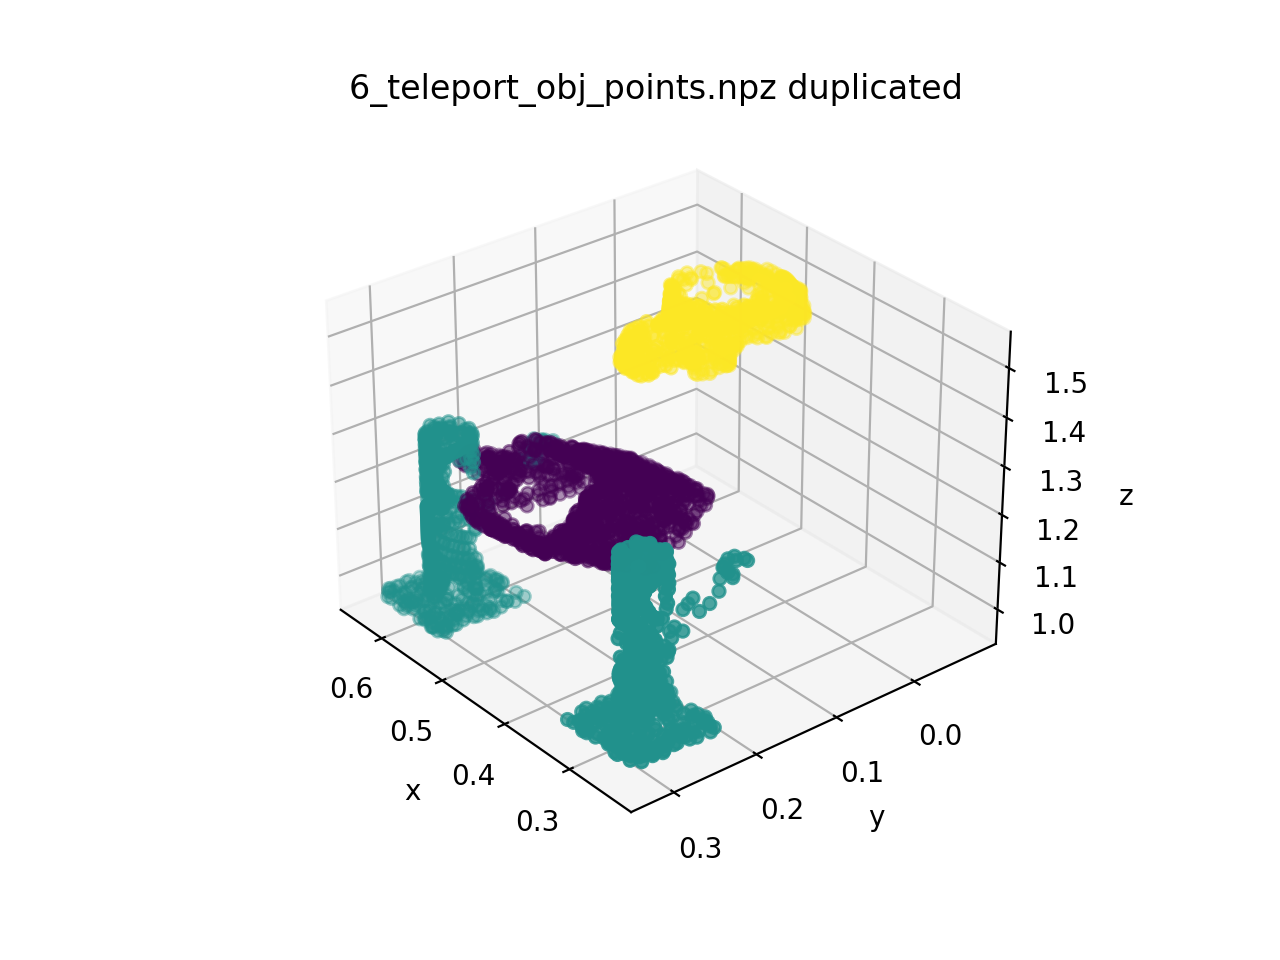

Text(0.5, 0, 'z')

In [73]:
data = np.load("train_data/renders/3_teleport_obj_points.npz")
data = {k: data[k] for k in data.files} # convert to dict

translation = np.array([-0.3, 0, 0])
rack_cloud = data['clouds'][data['classes'] == 1]
rack_cloud = rack_cloud + translation
data['clouds'] = np.concatenate([data['clouds'], rack_cloud], axis=0)

rack_classes = np.tile(data['classes'][data['classes'] == 1][0], (len(rack_cloud)))
data['classes'] = np.concatenate([data['classes'], rack_classes])

rack_colors = data['colors'][data['classes'] == 1]
data['colors'] = np.concatenate([data['colors'], rack_cloud], axis=0)



fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(data['clouds'][::30,0], data['clouds'][::30,1], data['clouds'][::30,2], c=data['classes'][::30]/2)

ax.set_title(filename.split("/")[-1] + " duplicated")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

# Duplicate rack arm

In [ ]:
data = np.load("train_data/renders/3_teleport_obj_points.npz")
data = {k: data[k] for k in data.files} # convert to dict

rack_cloud = data['clouds'][data['classes'] == 1]
rack_classes = np.tile(data['classes'][data['classes'] == 1][0], (len(rack_cloud)))
rack_colors = data['colors'][data['classes'] == 1]

rack_arm_idxs = np.where(
    rack_cloud[:,0] < 0.65 & rack_cloud[:,0] > 0.55 \
    & rack_cloud[:,1] < 0.28 & rack_cloud[:,1] > 0.22 \
    & rack_cloud[:,2] < 1.2 & rack_cloud[:,2] > 1.0
)
rack_classes[rack_arm_idxs] = 3

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(data['clouds'][::30,0], data['clouds'][::30,1], data['clouds'][::30,2], c=data['classes'][::30]/3)

ax.set_title(filename.split("/")[-1] + " duplicated")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')